In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')

from ce_utils import load_data, one_hot, test_batch_idxs, batch_flatten
from ce_utils import model_prob
from ce_utils import classification_metric
from ce_model import binary_model, ensemble_model

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [3]:
neg_img, neg_name = load_data('test', 'n', 'neg', data = 'sm_v2', extract_name = True)
redspot_img, redspot_name = load_data('test', 'h', 'redspot', data = 'sm_v2', extract_name = True)
angio_img, angio_name = load_data('test', 'h', 'angio', data = 'sm_v2', extract_name = True)
active_img, active_name = load_data('test', 'h', 'active', data = 'sm_v2', extract_name = True)
ero_img, ero_name = load_data('test', 'd', 'ero', data = 'sm_v2', extract_name = True)
ulcer_img, ulcer_name = load_data('test', 'd', 'ulcer', data = 'sm_v2', extract_name = True)
str_img, str_name = load_data('test', 'd', 'str', data = 'sm_v2', extract_name = True)

In [4]:
neg_label = one_hot(neg_img, 0)
redspot_label = one_hot(redspot_img, 1)
angio_label = one_hot(angio_img, 1)
active_label = one_hot(active_img, 1)
ero_label = one_hot(ero_img, 1)
ulcer_label = one_hot(ulcer_img, 1)
str_label = one_hot(str_img, 1)

print("negative:",neg_img.shape, neg_label.shape)
print("red spot:",redspot_img.shape, redspot_label.shape)
print("angioectasia:",angio_img.shape, angio_label.shape)
print("active_bleeding:",active_img.shape, active_label.shape)
print("erosion:",ero_img.shape, ero_label.shape)
print("ulcer:",ulcer_img.shape, ulcer_label.shape)
print("stricture:",str_img.shape, str_label.shape)

negative: (10927, 512, 512, 3) (10927, 2)
red spot: (973, 512, 512, 3) (973, 2)
angioectasia: (35, 512, 512, 3) (35, 2)
active_bleeding: (756, 512, 512, 3) (756, 2)
erosion: (1295, 512, 512, 3) (1295, 2)
ulcer: (1281, 512, 512, 3) (1281, 2)
stricture: (182, 512, 512, 3) (182, 2)


In [5]:
len(redspot_name) + len(angio_name) + len(active_name)

1764

In [6]:
len(ero_name) + len(ulcer_name) + len(str_name)

2758

In [7]:
len(redspot_name) + len(angio_name) + len(active_name) + len(ero_name) + len(ulcer_name) + len(str_name)

4522

In [8]:
np.random.choice(len(neg_name), 4522)

array([ 1393, 10762,  2180, ...,  1184,  2381,  1668])

In [9]:
neg2_img = neg_img[np.random.choice(len(neg_name), 4522)]
neg2_label = one_hot(neg2_img, 0)

In [10]:
neg2_img.shape

(4522, 512, 512, 3)

# Model Inference

In [11]:
nh_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'N1H9_' in i and 'core' not in i])
nd_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'N1D9_' in i and 'core' not in i])
b_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'B_' in i and 'core' not in i])

In [12]:
nh_list

['N1H9_2001101648_2940_val_acc_0.99_val_loss_0.031713',
 'N1H9_2001101656_3370_val_acc_0.99_val_loss_0.031599',
 'N1H9_2001101659_3550_val_acc_0.99_val_loss_0.025578',
 'N1H9_2001101705_3820_val_acc_1.00_val_loss_0.008359',
 'N1H9_2001101713_4250_val_acc_1.00_val_loss_0.006335']

In [13]:
nd_list

['N1D9_2001100152_4380_val_acc_0.98_val_loss_0.039794',
 'N1D9_2001100202_4900_val_acc_0.99_val_loss_0.039726',
 'N1D9_2001100204_4990_val_acc_0.99_val_loss_0.027827',
 'N1D9_2001100206_5120_val_acc_0.99_val_loss_0.026593',
 'N1D9_2001100219_5810_val_acc_0.99_val_loss_0.022532']

In [14]:
b_list

['B_2001060434_9410_val_acc_1.00_val_loss_0.019657',
 'B_2001060441_9870_val_acc_1.00_val_loss_0.011613',
 'B_2001060509_11910_val_acc_1.00_val_loss_0.009551',
 'B_2001060518_12540_val_acc_1.00_val_loss_0.008383',
 'B_2001060534_13690_val_acc_1.00_val_loss_0.006853',
 'B_2001081714_6900_val_acc_0.96_val_loss_0.094075',
 'B_2001081734_8800_val_acc_0.97_val_loss_0.077247',
 'B_2001081739_9300_val_acc_0.98_val_loss_0.059156',
 'B_2001081801_11400_val_acc_0.98_val_loss_0.050810',
 'B_2001081821_13300_val_acc_0.98_val_loss_0.042233',
 'B_2001100012_80_val_acc_0.60_val_loss_0.659025',
 'B_2001100013_150_val_acc_0.66_val_loss_0.650705',
 'B_2001100013_90_val_acc_0.57_val_loss_0.655705',
 'B_2001100014_160_val_acc_0.64_val_loss_0.616498',
 'B_2001100014_180_val_acc_0.68_val_loss_0.614124',
 'B_2001100015_10_val_acc_0.50_val_loss_0.691157',
 'B_2001100015_30_val_acc_0.62_val_loss_0.688692',
 'B_2001100015_50_val_acc_0.64_val_loss_0.606388',
 'B_2001100122_3070_val_acc_1.00_val_loss_0.034832',
 

In [15]:
nh_path = './model/' + nh_list[-1]
nd_path = './model/' + nd_list[-1]
b_path = './model/' + b_list[-1]

NH_model = binary_model(nh_path)
ND_model = binary_model(nd_path)
E_model = ensemble_model(nh_path, nd_path)
B_model = binary_model(b_path)

W0110 23:57:42.692286 140075835225856 deprecation_wrapper.py:119] From /mnt/disk1/project/SMhospital/capsule/ce_packages/ce_model.py:107: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0110 23:57:49.018344 140075835225856 deprecation_wrapper.py:119] From /mnt/disk1/project/SMhospital/capsule/ce_packages/ce_model.py:108: The name tf.train.import_meta_graph is deprecated. Please use tf.compat.v1.train.import_meta_graph instead.

W0110 23:57:49.333179 140075835225856 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [16]:
neg_e_output, neg_nh_output, neg_nd_output = model_prob(E_model, neg_img, model_type = 'ensemble')
redspot_e_output, redspot_nh_output, redspot_nd_output = model_prob(E_model, redspot_img, model_type = 'ensemble')
angio_e_output, angio_nh_output, angio_nd_output = model_prob(E_model, angio_img, model_type = 'ensemble')
active_e_output, active_nh_output, active_nd_output = model_prob(E_model, active_img, model_type = 'ensemble')
ero_e_output, ero_nh_output, ero_nd_output = model_prob(E_model, ero_img, model_type = 'ensemble')
ulcer_e_output, ulcer_nh_output, ulcer_nd_output = model_prob(E_model, ulcer_img, model_type = 'ensemble')
str_e_output, str_nh_output, str_nd_output  = model_prob(E_model, str_img, model_type = 'ensemble')

#: 10927 / Inference Time: 00:01:47
#: 973 / Inference Time: 00:00:10
#: 35 / Inference Time: 00:00:00
#: 756 / Inference Time: 00:00:07
#: 1295 / Inference Time: 00:00:12
#: 1281 / Inference Time: 00:00:12
#: 182 / Inference Time: 00:00:02


In [17]:
neg_b_output = model_prob(B_model, neg_img)
redspot_b_output = model_prob(B_model, redspot_img)
angio_b_output = model_prob(B_model, angio_img)
active_b_output = model_prob(B_model, active_img)
ero_b_output = model_prob(B_model, ero_img)
ulcer_b_output = model_prob(B_model, ulcer_img)
str_b_output  = model_prob(B_model, str_img)

#: 10927 / Inference Time: 00:00:52
#: 973 / Inference Time: 00:00:04
#: 35 / Inference Time: 00:00:00
#: 756 / Inference Time: 00:00:03
#: 1295 / Inference Time: 00:00:06
#: 1281 / Inference Time: 00:00:06
#: 182 / Inference Time: 00:00:00


In [18]:
neg2_e_output, neg2_nh_output, neg2_nd_output = model_prob(E_model, neg2_img, model_type = 'ensemble')
neg2_b_output = model_prob(B_model, neg2_img)

#: 4522 / Inference Time: 00:00:44
#: 4522 / Inference Time: 00:00:22


# Evaluation

In [19]:
cls = classification_metric()

## Accuracy per lesion

In [20]:
neg_nh_acc = cls.accuracy(neg_label, neg_nh_output)
redspot_nh_acc = cls.accuracy(redspot_label, redspot_nh_output)
angio_nh_acc = cls.accuracy(angio_label, angio_nh_output)
active_nh_acc = cls.accuracy(active_label, active_nh_output)

Accuracy: 95.66 %
Accuracy: 91.68 %
Accuracy: 100.00 %
Accuracy: 98.02 %


In [21]:
neg_nd_acc = cls.accuracy(neg_label, neg_nd_output)
ero_nd_acc = cls.accuracy(ero_label, ero_nd_output)
ulcer_nd_acc = cls.accuracy(ulcer_label, ulcer_nd_output)
str_nd_acc = cls.accuracy(str_label, str_nd_output)

Accuracy: 90.99 %
Accuracy: 96.83 %
Accuracy: 97.11 %
Accuracy: 91.21 %


In [22]:
neg_b_acc = cls.accuracy(neg_label, neg_b_output)
redspot_b_acc = cls.accuracy(redspot_label, redspot_b_output)
angio_b_acc = cls.accuracy(angio_label, angio_b_output)
active_b_acc = cls.accuracy(active_label, active_b_output)
ero_b_acc = cls.accuracy(ero_label, ero_b_output)
ulcer_b_acc = cls.accuracy(ulcer_label, ulcer_b_output)
str_b_acc = cls.accuracy(str_label, str_b_output)

Accuracy: 97.55 %
Accuracy: 87.67 %
Accuracy: 100.00 %
Accuracy: 98.15 %
Accuracy: 93.90 %
Accuracy: 92.51 %
Accuracy: 90.66 %


In [23]:
neg_e_acc = cls.accuracy(neg_label, neg_e_output)
redspot_e_acc = cls.accuracy(redspot_label, redspot_e_output)
angio_e_acc = cls.accuracy(angio_label, angio_e_output)
active_e_acc = cls.accuracy(active_label, active_e_output)
ero_e_acc = cls.accuracy(ero_label, ero_e_output)
ulcer_e_acc = cls.accuracy(ulcer_label, ulcer_e_output)
str_e_acc = cls.accuracy(str_label, str_e_output)

Accuracy: 88.51 %
Accuracy: 93.73 %
Accuracy: 100.00 %
Accuracy: 99.34 %
Accuracy: 97.92 %
Accuracy: 98.20 %
Accuracy: 92.31 %


In [24]:
neg2_nh_acc = cls.accuracy(neg2_label, neg2_nh_output)
neg2_nd_acc = cls.accuracy(neg2_label, neg2_nd_output)
neg2_b_acc = cls.accuracy(neg2_label, neg2_b_output)
neg2_e_acc = cls.accuracy(neg2_label, neg2_e_output)

Accuracy: 95.78 %
Accuracy: 90.60 %
Accuracy: 97.83 %
Accuracy: 88.30 %


## Confusion Matrix

In [25]:
nh_outputs = np.vstack([neg_nh_output, redspot_nh_output, angio_nh_output, active_nh_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label])

nh_CM = cls.con_mat(labels, nh_outputs)

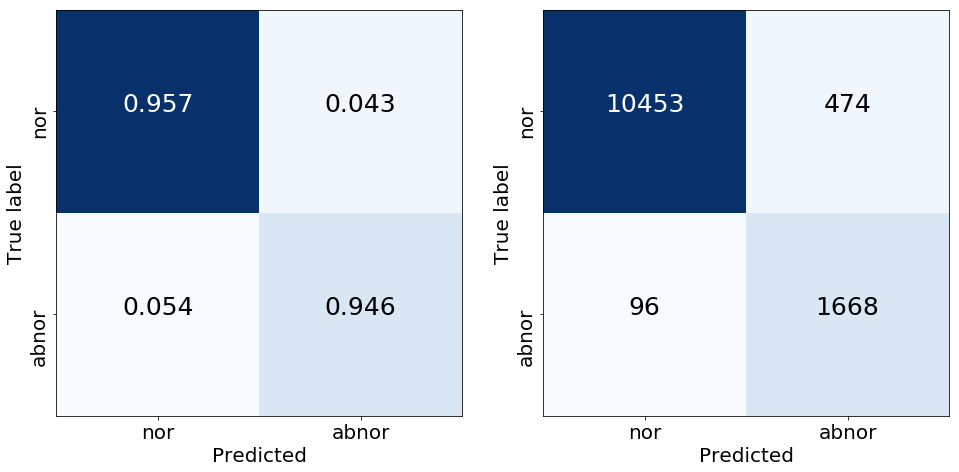

In [26]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

In [27]:
nd_outputs = np.vstack([neg_nd_output, ero_nd_output, ulcer_nd_output, str_nd_output])
labels = np.vstack([neg_label, ero_label, ulcer_label, str_label])

nd_CM = cls.con_mat(labels, nd_outputs)

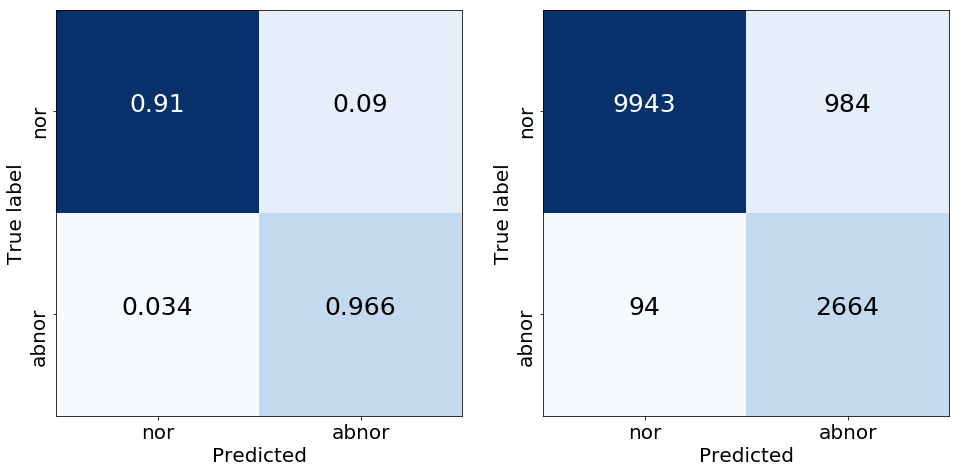

In [28]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

In [29]:
e_outputs = np.vstack([neg_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_CM = cls.con_mat(labels, e_outputs)

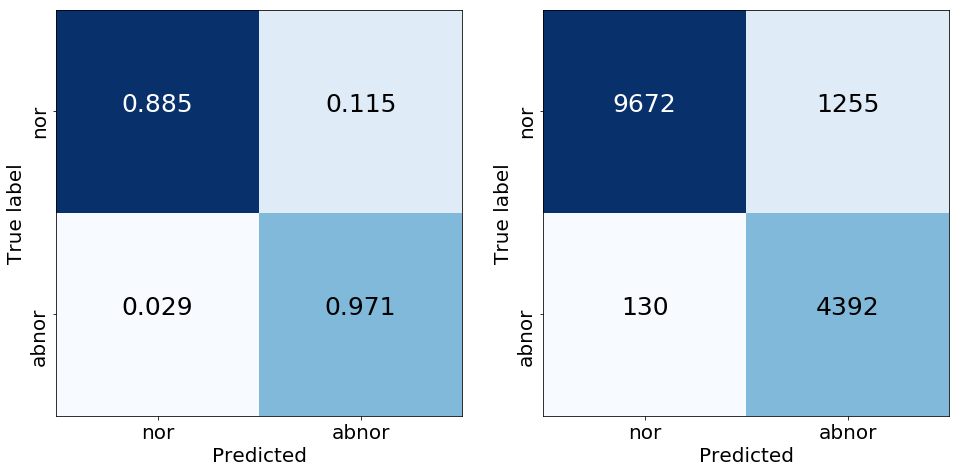

In [30]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(e_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(e_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

In [31]:
b_outputs = np.vstack([neg_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

b_CM = cls.con_mat(labels, b_outputs)

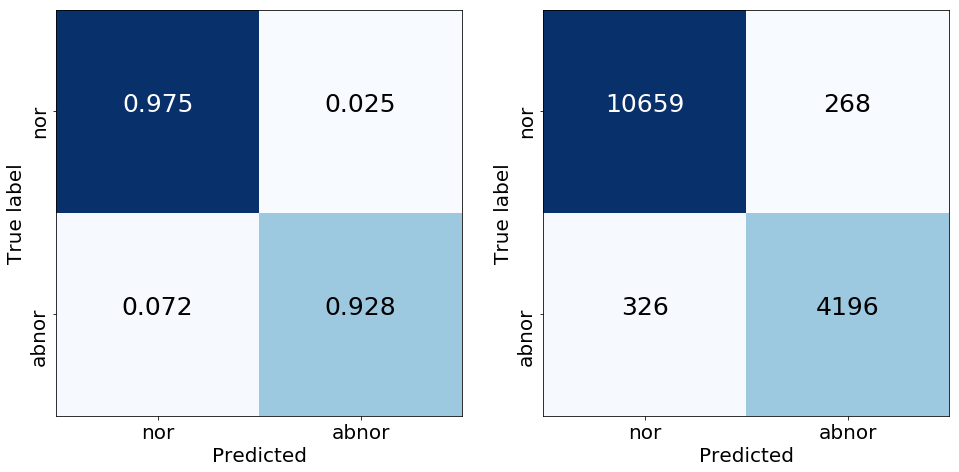

In [32]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(b_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(b_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

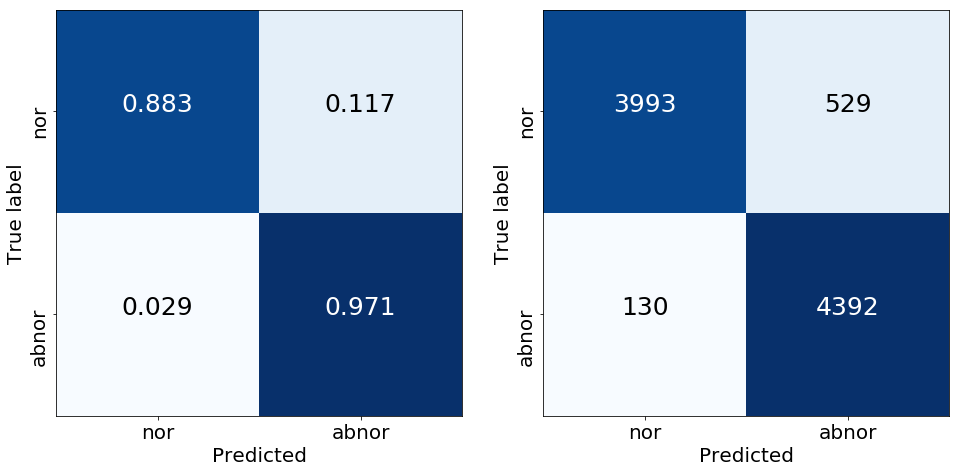

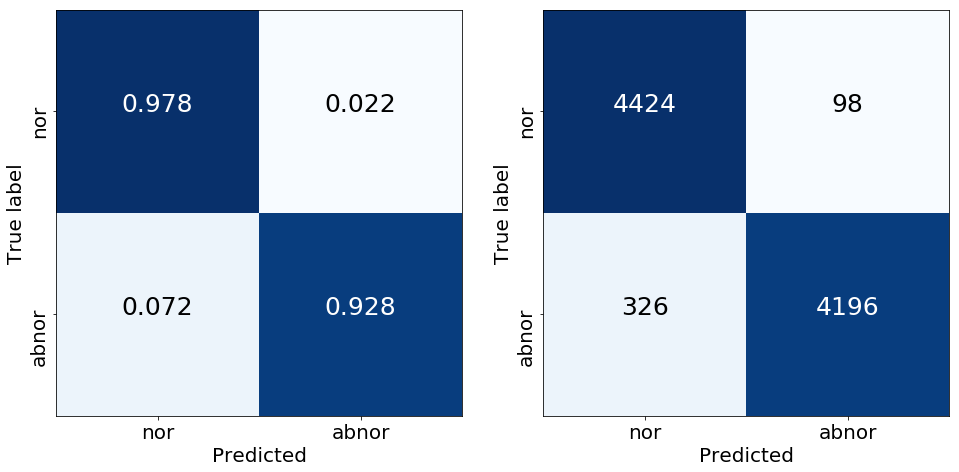

In [33]:
e_outputs = np.vstack([neg2_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg2_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_CM = cls.con_mat(labels, e_outputs)

plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(e_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(e_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

b_outputs = np.vstack([neg2_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
labels = np.vstack([neg2_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

b_CM = cls.con_mat(labels, b_outputs)

plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(b_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(b_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

## ROC curve

In [34]:
from scipy.stats import sem, t
from scipy import mean

def conf_interval(data, conf_level = 0.95, mode = 'value', metric = 'Accr'):
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + conf_level) / 2, n - 1)

    start = m - h
    end = m + h
    
    if mode == 'value':
        return m, start, end
    elif mode == 'print':
        return print("{} --- {:.2f} ({:.2f} ~ {:.2f})".format(metric, m, start, end))

In [35]:
from sklearn.model_selection import KFold

def k_fold_idx(n_fold, dataset):
    kf = KFold(n_splits = n_fold, shuffle = True)
    train_idxs = []
    test_idxs = []
    for train_idx, test_idx in kf.split(dataset):
        train_idxs.append(train_idx)
        test_idxs.append(test_idx)
    return train_idxs, test_idxs

In [36]:
n_g = 10

_, neg2_idxs = k_fold_idx(n_fold = n_g, dataset = neg2_label)
_, redspot_idxs = k_fold_idx(n_fold = n_g, dataset = redspot_label)
_, angio_idxs = k_fold_idx(n_fold = n_g, dataset = angio_label)
_, active_idxs = k_fold_idx(n_fold = n_g, dataset = active_label)
_, ero_idxs = k_fold_idx(n_fold = n_g, dataset = ero_label)
_, ulcer_idxs = k_fold_idx(n_fold = n_g, dataset = ulcer_label)
_, str_idxs = k_fold_idx(n_fold = n_g, dataset = str_label)

In [37]:
from sklearn.metrics import roc_curve, auc

e_aucs, b_aucs = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg2_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg2_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])
    e_outputs = np.vstack([neg2_e_output[n_idx], redspot_e_output[r_idx], angio_e_output[an_idx], active_e_output[ac_idx], 
                           ero_e_output[e_idx], ulcer_e_output[u_idx], str_e_output[s_idx]])
    labels = np.vstack([neg2_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])
    e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
    b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])
    e_aucs.append(auc(e_fpr, e_tpr))
    b_aucs.append(auc(b_fpr, b_tpr))

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


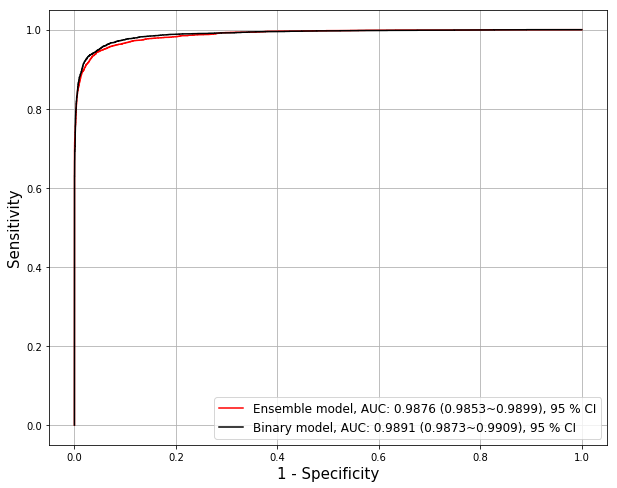

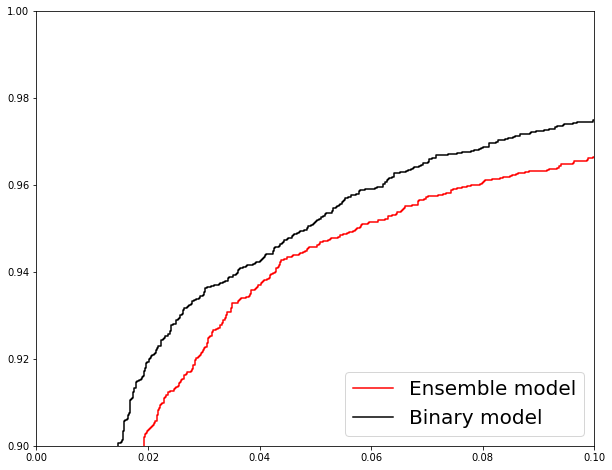

In [38]:
e_auc_m, e_auc_l, e_auc_u = conf_interval(e_aucs, mode = 'value')
b_auc_m, b_auc_l, b_auc_u = conf_interval(b_aucs, mode = 'value')

b_outputs = np.vstack([neg_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
e_outputs = np.vstack([neg_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(e_auc_m, e_auc_l, e_auc_u))
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(b_auc_m, b_auc_l, b_auc_u))
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model")
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model")
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])
plt.legend(fontsize = 20, loc = 4)
fig.show()

## Statistics

![image](http://mblogthumb3.phinf.naver.net/20121114_106/istech7_1352875002440GYyqh_PNG/%B5%CE%C1%FD%B4%DC%C2%F7%C0%CC_%B0%CB%C1%A4%B9%E6%B9%FD%C8%E5%B8%A7%B5%B5.png?type=w2)

![image](https://t1.daumcdn.net/cfile/tistory/2743524658F2520C2A)

https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F1378B94E4F9C187F23

In [39]:
e_CM, b_CM = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg2_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg2_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])
    e_outputs = np.vstack([neg2_e_output[n_idx], redspot_e_output[r_idx], angio_e_output[an_idx], active_e_output[ac_idx], 
                           ero_e_output[e_idx], ulcer_e_output[u_idx], str_e_output[s_idx]])
    labels = np.vstack([neg2_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])
    print(labels.shape)
    e_CM.append(cls.con_mat(labels, e_outputs)), b_CM.append(cls.con_mat(labels, b_outputs))

(909, 2)
(908, 2)
(906, 2)
(905, 2)
(905, 2)
(903, 2)
(902, 2)
(902, 2)
(902, 2)
(902, 2)


In [40]:
b_metrices = []
e_metrices = []

for e_cm, b_cm in zip(e_CM, b_CM):
    b_metrices.append(cls.cm2metric(b_cm))
    e_metrices.append(cls.cm2metric(e_cm))
    
b_metrices = np.asarray(b_metrices)
e_metrices = np.asarray(e_metrices)

In [41]:
b_metrices

array([[0.96149615, 0.94517544, 0.97792494, 0.9465812 , 0.97732426],
       [0.95484581, 0.93186813, 0.97792494, 0.93459916, 0.97695853],
       [0.94812362, 0.92290749, 0.97345133, 0.92631579, 0.97215777],
       [0.95248619, 0.92935982, 0.97566372, 0.93234672, 0.97453704],
       [0.95469613, 0.92935982, 0.9800885 , 0.93263158, 0.97906977],
       [0.95570321, 0.92461197, 0.98672566, 0.92916667, 0.9858156 ],
       [0.96674058, 0.94444444, 0.98893805, 0.9470339 , 0.98837209],
       [0.95343681, 0.93111111, 0.97566372, 0.93432203, 0.9744186 ],
       [0.94345898, 0.91111111, 0.97566372, 0.91683992, 0.97387173],
       [0.94013304, 0.90888889, 0.97123894, 0.91458333, 0.96919431]])

In [42]:
e_metrices

array([[0.93729373, 0.98903509, 0.88520971, 0.98768473, 0.89662028],
       [0.91189427, 0.96703297, 0.85651214, 0.96277916, 0.87128713],
       [0.92494481, 0.969163  , 0.88053097, 0.96601942, 0.89068826],
       [0.93701657, 0.97571744, 0.89823009, 0.9736211 , 0.9057377 ],
       [0.91491713, 0.9602649 , 0.86946903, 0.95620438, 0.8805668 ],
       [0.94905869, 0.97560976, 0.92256637, 0.97429907, 0.92631579],
       [0.93348115, 0.97111111, 0.8960177 , 0.96889952, 0.90289256],
       [0.92461197, 0.98      , 0.86946903, 0.97761194, 0.882     ],
       [0.91574279, 0.96222222, 0.86946903, 0.95853659, 0.8800813 ],
       [0.92239468, 0.96222222, 0.88274336, 0.95913462, 0.8909465 ]])

In [43]:
print("95 % CI\n")

print('Binary model')
conf_interval(100*b_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*b_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*b_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*b_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*b_metrices[:, 4], mode = 'print', metric = 'PPV')
print('')
print('Ensemble model')
conf_interval(100*e_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*e_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*e_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*e_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*e_metrices[:, 4], mode = 'print', metric = 'PPV')

95 % CI

Binary model
Accr --- 95.31 (94.75 ~ 95.87)
Sen --- 92.79 (91.93 ~ 93.64)
Spec --- 97.83 (97.43 ~ 98.23)
NPV --- 93.14 (92.38 ~ 93.91)
PPV --- 97.72 (97.29 ~ 98.14)

Ensemble model
Accr --- 92.71 (91.86 ~ 93.56)
Sen --- 97.12 (96.48 ~ 97.77)
Spec --- 88.30 (86.95 ~ 89.66)
NPV --- 96.85 (96.14 ~ 97.56)
PPV --- 89.27 (88.13 ~ 90.42)


### Equal-Variance Test

In [44]:
from scipy.stats import bartlett

accr_stats = bartlett(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = bartlett(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = bartlett(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = bartlett(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = bartlett(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("bartlett test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("bartlett test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("bartlett test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("bartlett test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("bartlett test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

bartlett test for accuracy: 1.411, pvalue=0.234965119213
bartlett test for sensitivity: 0.642, pvalue=0.422953857869
bartlett test for specificity: 10.399, pvalue=0.001261143104
bartlett test for negative predictive values: 0.042, pvalue=0.838005836623
bartlett test for positive predictive values: 7.274, pvalue=0.006994248532


In [45]:
from scipy.stats import levene

accr_stats = levene(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = levene(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = levene(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = levene(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = levene(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("levene test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("levene test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("levene test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("levene test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("levene test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

levene test for accuracy: 1.646, pvalue=0.215787784101
levene test for sensitivity: 0.228, pvalue=0.638752088609
levene test for specificity: 6.119, pvalue=0.023559698990
levene test for negative predictive values: 0.015, pvalue=0.902404093185
levene test for positive predictive values: 4.535, pvalue=0.047261960087


### Normality Test

In [46]:
from scipy.stats import ks_2samp

accr_stats = ks_2samp(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ks_2samp(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ks_2samp(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ks_2samp(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ks_2samp(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("Kolmogorov-Smirnov test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("Kolmogorov-Smirnov test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("Kolmogorov-Smirnov test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("Kolmogorov-Smirnov test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("Kolmogorov-Smirnov test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

Kolmogorov-Smirnov test for accuracy: 0.900, pvalue=0.000216501764
Kolmogorov-Smirnov test for sensitivity: 1.000, pvalue=0.000010825088
Kolmogorov-Smirnov test for specificity: 1.000, pvalue=0.000010825088
Kolmogorov-Smirnov test for negative predictive values: 1.000, pvalue=0.000010825088
Kolmogorov-Smirnov test for positive predictive values: 1.000, pvalue=0.000010825088


### Wilcoxon signed-ranks test (not normal and paired group)

In [47]:
from scipy.stats import wilcoxon

accr_stats = wilcoxon(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = wilcoxon(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = wilcoxon(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = wilcoxon(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = wilcoxon(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("wilcoxon signed-ranks test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("wilcoxon signed-ranks test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("wilcoxon signed-ranks test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("wilcoxon signed-ranks test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("wilcoxon signed-ranks test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

wilcoxon signed-ranks test for accuracy: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for sensitivity: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for specificity: 0.000, pvalue=0.005033508201
wilcoxon signed-ranks test for negative predictive values: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for positive predictive values: 0.000, pvalue=0.005062032126


### Paired two-sample t-Test (normal and paired group)

In [48]:
from scipy.stats import ttest_rel

accr_stats = ttest_rel(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ttest_rel(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ttest_rel(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ttest_rel(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ttest_rel(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("t-statistics for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("t-statistics for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("t-statistics for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("t-statistics for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("t-statistics for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

t-statistics for accuracy: 7.411, pvalue=0.000040569287
t-statistics for sensitivity: -14.851, pvalue=0.000000123047
t-statistics for specificity: 18.057, pvalue=0.000000022318
t-statistics for negative predictive values: -13.147, pvalue=0.000000352647
t-statistics for positive predictive values: 19.272, pvalue=0.000000012587


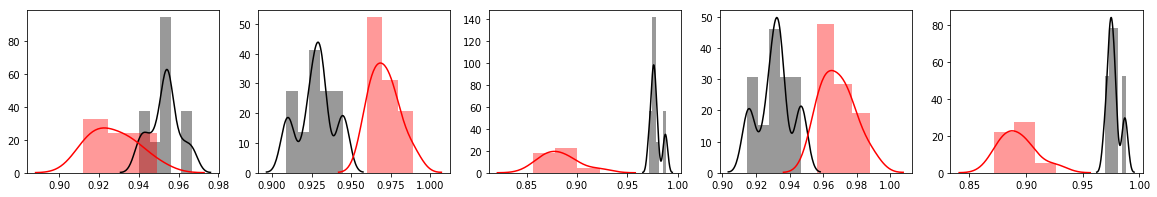

In [49]:
## Distribution by metric

import seaborn as sns

fig, axes = plt.subplots(ncols = 5)
fig.set_size_inches(20, 3)

sns.set_style({'axes.grid' : True})

sns.distplot(b_metrices[:, 0], color='k', ax = axes[0])
sns.distplot(e_metrices[:, 0], color='r', ax = axes[0])
sns.distplot(b_metrices[:, 1], color='k', ax = axes[1])
sns.distplot(e_metrices[:, 1], color='r', ax = axes[1])
sns.distplot(b_metrices[:, 2], color='k', ax = axes[2])
sns.distplot(e_metrices[:, 2], color='r', ax = axes[2])
sns.distplot(b_metrices[:, 3], color='k', ax = axes[3])
sns.distplot(e_metrices[:, 3], color='r', ax = axes[3])
sns.distplot(b_metrices[:, 4], color='k', ax = axes[4])
sns.distplot(e_metrices[:, 4], color='r', ax = axes[4])

fig.show()